<a href="https://colab.research.google.com/github/BryanCoboF/dataScienceStudy/blob/main/optCosechaCVXpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Configuracion de librerias
%config IPCompleter.greedy=True

!pip install tabulate
import cvxpy as cp
from tabulate import tabulate
import pandas as pd
import numpy as np
import xlrd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import files
from google.colab import drive
import calendar

In [179]:

def importDriveData():
  #Importar datos de Drive
  drive.mount('/content/drive') # Permite ingresar a drive desde las carpetas de drive
  df = pd.read_excel("/content/drive/MyDrive/PB/BaseOpt8Ene2024.xlsx") # Carga el excel de datos de proyeccion, si se necesita cambiar el archivo se debe modificar el link
  titles = df.columns
  return df, titles


def semanasPorMes():
  #Calculo de las semanas por cada mes contando la cantidad de días lunes que tiene cada semana
  anioAnalisis = -1
  while anioAnalisis <0 or anioAnalisis >=2100:
    anioAnalisis = int(input("Ingrese el año a analizar las semanas por mes: "))
  semanasMes = np.arange(1, 13)
  diasMes = np.arange(1, 13)
  for month in range(1, 13):
    # Obtener el número de semanas para el mes actual
    calendario = calendar.monthcalendar(anioAnalisis, month)
    num_lunes = sum(1 for semana in calendario if semana[calendar.MONDAY] != 0) # conteo de dias lunes por mes
    semanasMes [month - 1] = num_lunes
  print("Año a optimizar: ", anioAnalisis)
  print("Semanas por mes: " ,semanasMes)
  print("Semanas al año: ",np.sum(semanasMes))
  return semanasMes


def volumenPorMes(weeksByMonth):
  # Calcula el volumen deseado por mes
  volAnualDeseado = float(input("Ingrese el volumen deseado anual: "))
  VolDeseado = np.arange(1, 13)
  for i in range(12):
    VolDeseado [i] = (round((volAnualDeseado/np.sum(weeksByMonth))*weeksByMonth[i],0))
  print("Volumen deseado por mes: ",VolDeseado)
  print("Volumen deseado al año: ", np.sum(VolDeseado))
  return VolDeseado, volAnualDeseado



def dataInteres(df):
  # Extrae los datos del df y crea las matrices y vectores de interes (Edad, )
  # df[[' ENE',' FEB', ' MAR',' ABR',' MAY', ' JUN',' JUL', ' AGO', ' SEP', ' OCT', ' NOV' , ' DIC']].copy()
  sitioAnio = df['Sitio-AñoPlantación']
  areaTotal = df['Sum of Área Total del Lote (Ha)']
  areaNeta = df['Sum of Área Neta del Lote (Ha)']
  perfilRend = df['Average of Perfil Rendimiento (Sitio)']
  edades = df[['Sum of Edad pond ENE','Sum of Edad pond FEB', 'Sum of Edad pond MAR','Sum of Edad pond ABR','Sum of Edad pond MAY', 'Sum of Edad pond JUN','Sum of Edad pond JUL', 'Sum of Edad pond AGO', 'Sum of Edad pond SEP', 'Sum of Edad pond OCT', 'Sum of Edad pond NOV' , 'Sum of Edad pond DIC']].copy()
  rendNeto = df[['Sum of Rend pond ENE','Sum of Rend pond FEB', 'Sum of Rend pond MAR','Sum of Rend pond ABR','Sum of Rend pond MAY', 'Sum of Rend pond JUN','Sum of Rend pond JUL', 'Sum of Rend pond AGO', 'Sum of Rend pond SEP', 'Sum of Rend pond OCT', 'Sum of Rend pond NOV' , 'Sum of Rend pond DIC']].copy()
  accesibilidad = df[['Sum of AccesibilidadENE','Sum of AccesibilidadFEB', 'Sum of AccesibilidadMAR','Sum of AccesibilidadABR','Sum of AccesibilidadMAY', 'Sum of AccesibilidadJUN','Sum of AccesibilidadJUL', 'Sum of AccesibilidadAGO', 'Sum of AccesibilidadSEP', 'Sum of AccesibilidadOCT', 'Sum of AccesibilidadNOV' , 'Sum of AccesibilidadDIC']].copy()
  costoActBio = df['Sum of CostoActBio Pond']
  costoOpe = df[['Sum of Costo Operacional pond ENE','Sum of Costo Operacional pond FEB', 'Sum of Costo Operacional pond MAR','Sum of Costo Operacional pond ABR','Sum of Costo Operacional pond MAY', 'Sum of Costo Operacional pond JUN','Sum of Costo Operacional pond JUL', 'Sum of Costo Operacional pond AGO', 'Sum of Costo Operacional pond SEP', 'Sum of Costo Operacional pond OCT', 'Sum of Costo Operacional pond NOV' , 'Sum of Costo Operacional pond DIC']].copy()
  porcR8 = df[['Sum of %R8 pond ENE','Sum of %R8 pond FEB', 'Sum of %R8 pond MAR','Sum of %R8 pond ABR','Sum of %R8 pond MAY', 'Sum of %R8 pond JUN','Sum of %R8 pond JUL', 'Sum of %R8 pond AGO', 'Sum of %R8 pond SEP', 'Sum of %R8 pond OCT', 'Sum of %R8 pond NOV' , 'Sum of %R8 pond DIC']].copy()
  promR8 = df[['Sum of Prom R8 pond ENE','Sum of Prom R8 pond FEB', 'Sum of Prom R8 pond MAR','Sum of Prom R8 pond ABR','Sum of Prom R8 pond MAY', 'Sum of Prom R8 pond JUN','Sum of Prom R8 pond JUL', 'Sum of Prom R8 pond AGO', 'Sum of Prom R8 pond SEP', 'Sum of Prom R8 pond OCT', 'Sum of Prom R8 pond NOV' , 'Sum of Prom R8 pond DIC']].copy()
  porcR11 = df[['Sum of %R11 pond ENE','Sum of %R11 pond FEB', 'Sum of %R11 pond MAR','Sum of %R11 pond ABR','Sum of %R11 pond MAY', 'Sum of %R11 pond JUN','Sum of %R11 pond JUL', 'Sum of %R11 pond AGO', 'Sum of %R11 pond SEP', 'Sum of %R11 pond OCT', 'Sum of %R11 pond NOV' , 'Sum of %R11 pond DIC']].copy()
  promR11 = df[['Sum of Prom R11 pond ENE','Sum of Prom R11 pond FEB', 'Sum of Prom R11 pond MAR','Sum of Prom R11 pond ABR','Sum of Prom R11 pond MAY', 'Sum of Prom R11 pond JUN','Sum of Prom R11 pond JUL', 'Sum of Prom R11 pond AGO', 'Sum of Prom R11 pond SEP', 'Sum of Prom R11 pond OCT', 'Sum of Prom R11 pond NOV' , 'Sum of Prom R11 pond DIC']].copy()
  raleo = df['Average of Raleo']
  return areaTotal, areaNeta, edades, rendNeto, perfilRend, accesibilidad, costoActBio, costoOpe, porcR8, promR8, porcR11, promR11, raleo, sitioAnio



def restrPlanificacion(matrRend, matrEdades, matrAcceso, vecRaleo): # Restringe edad, accesibilidad y raleo
  # Ingreso de datos deseados y validaciones
  matrRendRest = matrRend.copy()
  restEdad = 2
  restAcceso = 2
  restRaleo = 2
  edadMin = 0
  areaMax = 0
  while areaMax <=1 or areaMax >= 1000:
    areaMax = float(input("Ingrese el area maxima de cosecha por mes para una hacienda: "))
  while edadMin <=1 or edadMin >= 80:
    edadMin = float(input("Ingrese la edad minima de cosecha deseada: "))
  while restEdad !=0 and restEdad !=1:
    restEdad = float(input("Desea restringir edad? (SI: Ingrese 1,  NO: Ingrese 0) : "))
  while restAcceso != 0 and restAcceso !=1:
    restAcceso = float(input("Desea restringir accesibilidad? (SI: Ingrese 1,  NO: Ingrese 0) : "))
  while restRaleo != 0 and restRaleo !=1:
    restRaleo = float(input("Desea restringir Raleo? (SI: Ingrese 1,  NO: Ingrese 0) : "))

  filas, columnas = matrRend.shape
  if restEdad == 1: # Restriccion de edad
    for i in range(filas):
      for j in range(columnas):
        if matrEdades.iat[i,j] < edadMin:
          matrRendRest.iat[i,j] = 0
  if restAcceso == 1: # Restriccion de acceso
    for i in range(filas):
      for j in range(columnas):
        if matrAcceso.iat[i,j] == 0:
          matrRendRest.iat[i,j] = 0
  if restRaleo == 1: # Restriccion de raleo
    for i in range(filas):
      for j in range(columnas):
        if vecRaleo.iat[i] == 1:
          if j<=5:
            matrRendRest.iat[i,j] = 0
  return matrRendRest, filas, columnas, areaMax


def modeloOptimizacion(fil, col, areaNeta, costoAB, rendimientos, promR8, promR11, porcR8, porcR11, areaMax, volAnual, volMensual):
  areaRes = cp.Variable((fil, col))

  titus = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

  # Funcion objetivo
  #objFunction = cp.Minimize(-0.1*cp.sum(cp.multiply(areaRes, rendimientos))+0.3*cp.sum(areaRes)+0.6*cp.sum(areaRes.T @ costoAB))   # Multivariable
  #objFunction = cp.Minimize(cp.sum(cp.multiply(areaRes, rendimientos)))
  objFunction = cp.Minimize(cp.sum(areaRes.T @ costoAB))

  # Restricciones
  restricciones = [areaRes >= 0]  # No areas negativas
  restricciones.append(areaRes <= areaMax) # Area maxima de cosecha mensual por hacienda (ingresado por el usuario)
  restricciones.append(cp.sum(cp.multiply(areaRes, rendimientos)) == volAnual)


  for i in range(fil):
    for j in range(col):
      restricciones.append(areaRes[i,j] <= areaNeta.iat[i]) # Restriccion para que las areas no sean mayores al area neta
      if rendimientos.iat[i,j] == 0:
        restricciones.append(areaRes[i,j] == 0)  # Si un valor de la matriz de rendimientos es 0 el area tambien

  for i in range(filas):
    restricciones.append(cp.sum(areaRes[i,:]) <= areaNeta.iat[i]) #La suma de las areas cosechadas debe ser menor al area neta

  for j in range(columnas):
    volMes = 0
    for i in range(filas):
      volMes += areaRes[i,j]*rendimientos.iat[i,j]
    restricciones.append(volMes <= volMensual[j])
    restricciones.append(volMes >= volMensual[j]-volMensual[j]*0.01)

  # Restricciones de rendimiento
  restRend = 2
  rendMin = 0
  rendMax = 0
  areaMinMensual = np.zeros(12)
  areaMaxMensual = np.zeros(12)
  titus = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
  while restRend !=0 and restRend !=1:
    restRend = float(input("Desea restringir rendimientos mensuales (SI: Ingrese 1,  NO: Ingrese 0) : "))
  if restRend == 1: # Si restringir rendimientos
    while rendMin <= 1000 or rendMin >= 100000:
      rendMin = float(input("Ingrese el rendimiento minimo mensual: "))
    while rendMax <= 1000 or rendMin >= 100000:
      rendMax = float(input("Ingrese el rendimiento maximo mensual: "))
      if rendMax <= rendMin:
        rendMax = 0
        print('El rendimiento maximo mensual debe ser mayor que el rendimiento minimo')
    for i in range(len(areaMinMensual)):
      areaMinMensual[i] = volMensual[i]/rendMax
    for i in range(len(areaMaxMensual)):
      areaMaxMensual[i] = volMensual[i]/rendMin
    print('Areas minimas a restringir')
    print(tabulate([areaMinMensual], headers=titus, tablefmt='fancy_grid', floatfmt=".0f" ))
    print('Areas maximas a restringir')
    print(tabulate([areaMaxMensual], headers=titus, tablefmt='fancy_grid', floatfmt=".0f" ))
    for i in range(columnas):
      restricciones.append(cp.sum(areaRes[:,i]) <= areaMaxMensual[i]) #Aplica restriccion de areas maximas para el rendimiento mínimo
      restricciones.append(cp.sum(areaRes[:,i]) >= areaMinMensual[i]) #Aplica restriccion de areas minimas para el rendimiento maximo

  # Restricciones de costo
  restCost = 2
  cosMin = 0
  cosMax = 0
  arCosMinMensual = np.zeros(12)
  arCosMaxMensual = np.zeros(12)
  while restCost !=0 and restCost !=1:
    restCost = float(input("Desea restringir costos mensuales (SI: Ingrese 1,  NO: Ingrese 0) : "))
  if restCost == 1: # Si restringir costos
    while cosMin <= 1 or cosMin >= 1000:
      cosMin = float(input("Ingrese el costo minimo mensual: "))
    while cosMax <= 1 or cosMax >= 1000:
      cosMax = float(input("Ingrese el costo maximo mensual: "))
      if cosMax <= cosMin:
        cosMax = 0
        print('El costo maximo mensual debe ser mayor que el costo minimo')
    for i in range(len(arCosMinMensual)):
      arCosMinMensual[i] = (volMensual[i]*cosMin)
      arCosMaxMensual[i] = (volMensual[i]*cosMax)
    print('Costos minimos a restringir')
    print(tabulate([arCosMinMensual], headers=titus, tablefmt='fancy_grid', floatfmt=".0f" ))
    print('Costos maximos a restringir')
    print(tabulate([arCosMaxMensual], headers=titus, tablefmt='fancy_grid', floatfmt=".0f" ))
    for j in range(columnas):
        restricciones.append(cp.sum(areaRes[:,j]*costoAB[:])*1000 <= arCosMaxMensual)
        restricciones.append(cp.sum(areaRes[:,j]*costoAB[:])*1000 >= arCosMinMensual)


  modeloOpt = cp.Problem(objFunction, restricciones) # Definicion del modelo
  resOpt = modeloOpt.solve(verbose=True)

  areasResultantes = pd.DataFrame(areaRes.value, columns = titus)
  areasResultantes = areasResultantes.applymap(lambda x: x if x >= 0.01 or x<=-0.01 else 0)

  return areasResultantes



def presentaResultados(fil, col, areasOpt, rendim, sitioAnio, arNeta, arTot, costoHa):
  # Presentacion de areas resultantes y remanentes
  titus = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
  volRes = areasOpt.copy()
  areasNetasResul = areasOpt.copy()
  areasTotResul = areasOpt.copy()
  costoResul = areasOpt.copy()

  # Presentacion de areas netas cosechadas por sitio y mes y calculo de remanentes
  areasNetasResul['Area cosechada'] = areasNetasResul.sum(axis=1)
  areasNetasResul.insert(0, 'Areas Netas', arNeta)  # Incluye las areas netas de cada sitio al df
  areasNetasResul.insert(0, 'Sitio-Año', sitioAnio)  # Incluye el sitio y año de plantacion al df de areas resultantes
  areasNetasResul['Area Remanente'] = areasNetasResul['Areas Netas'] - areasNetasResul['Area cosechada']
  print(tabulate(areasNetasResul, headers='keys', tablefmt='fancy_grid', floatfmt=".1f"))

  #Calculo de matriz de areas totales AB cosechadas
  for i in range(filas):
    for j in range(columnas):
      if areasOpt.iat[i,j] > 0:
        areasTotResul.iat[i, j] = (areasOpt.iat[i, j] / arNeta.iat[i]) * arTot.iat[i]

  #Calcula la matriz de volumenes
  for i in range(fil):
    for j in range(col):
      volRes.iat[i,j] = areasOpt.iat[i,j]*rendim.iat[i,j]

  # Calcula la matriz de costos
  for i in range(fil):
    for j in range(col):
      costoResul.iat[i,j] = areasOpt.iat[i,j]*costoHa.iat[i]

  # Calcula los resultados mensuales y anuales
  varsResMensual = ['Volumen mensual', 'Área Neta mensual', 'Área Total mensual', 'Costo [$/kbft]']
  volMensual = volRes.sum()  # Vol Mensual
  areaMensualNet = areasOpt.sum() # Area mensual
  areaMensualTot = areasTotResul.sum() # Area total AB
  costoMensual = (costoResul.sum() / volRes.sum())*1000  # Costos mensuales
  resMensual = pd.concat([volMensual, areaMensualNet, areaMensualTot, costoMensual], axis=1, keys=varsResMensual)  # Creacion de matriz df
  # Rendimientos
  resMensual ['Rendimiento Neto mensual'] = resMensual['Volumen mensual'] / resMensual['Área Neta mensual']
  resMensual ['Rendimiento Total mensual'] = resMensual['Volumen mensual'] / resMensual['Área Total mensual']

  # Impresion de datos en tabla
  print(tabulate(resMensual.T, headers='keys', tablefmt='fancy_grid', floatfmt=".0f"))


  # Graficación
  fig, ax = plt.subplots(2,2, figsize=(14,6))
  plt.subplots_adjust(wspace=0.1, hspace=0.4)
  # Volumen resultante
  promVolAnual = volMensual.mean()
  volMensual.plot(ax=ax[0, 0], color='green', linewidth =2, label = 'Volumen mensual')
  for i, vol in enumerate(volMensual):
    ax[0, 0].text(i, vol, f'{vol:.0f}', ha='center', va='bottom', fontsize=6)
  ax [0, 0].tick_params(axis='both', which='major', labelsize=6)
  ax [0, 0].set_xlabel('Meses', fontsize=8)
  ax [0, 0].set_ylabel('Volumen [bft]', fontsize=8)
  ax [0, 0].set_title('Volumen a cosechar por mes', fontsize=10)
  ax [0, 0].axhline(y=promVolAnual, color='blue', linestyle='--',linewidth = 1, label='Promedio Anual')
  ylim = ax[0, 0].get_ylim()
  yp = ylim[1]
  # Obtener el límite máximo del eje x
  xlim = ax[0, 0].get_xlim()
  xp = xlim[1]  # Coloca el texto en el extremo derecho del eje x
  ax [0, 0].set_ylim(volMensual.min()-150000, volMensual.max()+150000)
  ax [0, 0].text(xp-1.5,yp+50000,f'Promedio Anual: {promVolAnual:.0f}', fontsize=6, ha='center')
  ax [0, 0].legend(fontsize=6, loc = 'lower right')

  #Areas
  promAreaAnual = areaMensualTot.mean()
  sumAreaAnual = areaMensualTot.sum()
  areaMensualTot.plot(ax=ax[0, 1], color='green', linewidth = 2, label = 'Área mensual')
  for i, ar in enumerate(areaMensualTot):
    ax[0, 1].text(i, ar, f'{ar:.1f}', ha='center', va='bottom', fontsize=6)
  ax [0, 1].tick_params(axis='both', which='major', labelsize=6)
  ax [0, 1].set_xlabel('Meses', fontsize=8)
  ax [0, 1].set_ylabel('Área [Ha]', fontsize=8)
  ax [0, 1].set_title('Áreas a cosechar por mes', fontsize=10)
  ax [0, 1].axhline(y=promAreaAnual, color ='blue', linestyle='--', linewidth = 1, label='Promedio Anual')
  ylim2 = ax[0, 1].get_ylim() # Obtiene el limite de y
  yp2 = ylim2[1]  # Utiliza solo el limite superior para grafricar arriba
  xlim2 = ax[0, 1].get_xlim()
  xp2 = xlim2[1]
  ax [0, 1].text(xp2-1,yp2+5,f'Promedio Anual: {promAreaAnual:.0f} \n Suma Anual: {sumAreaAnual:.0f}', fontsize=6, ha='center')
  ax [0, 1].set_ylim(areaMensualTot.min()-20, areaMensualTot.max()+20)
  ax [0, 1].legend(fontsize=6, loc = 'lower right')

  #Rendimientos
  promRendAnual =  resMensual['Rendimiento Total mensual'].mean()
  resMensual['Rendimiento Total mensual'].plot(ax=ax[1, 0], color='green', linewidth = 2, label = 'Rendimiento mensual')
  for i, re in enumerate(resMensual['Rendimiento Total mensual']):
    ax[1, 0].text(i, re, f'{re:.0f}', ha='center', va='bottom', fontsize=6)
  ax [1, 0].tick_params(axis='both', which='major', labelsize=6)
  ax [1, 0].set_xlabel('Meses', fontsize=8)
  ax [1, 0].set_ylabel('Rendimiento [bft/Ha]', fontsize=8)
  ax [1, 0].set_title('Rendimientos por mes', fontsize=10)
  ax [1, 0].axhline(y=promRendAnual, color ='blue', linestyle='--', linewidth = 1, label='Promedio Anual')
  ylim3 = ax[1, 0].get_ylim() # Obtiene el limite de y
  yp3 = ylim3[1]  # Utiliza solo el limite superior para grafricar arriba
  xlim3 = ax[1, 0].get_xlim()
  xp3 = xlim3[1]
  ax [1, 0].text(xp3-1.5,yp3+300,f'Promedio Anual: {promRendAnual:.0f}', fontsize=6, ha='center')
  ax [1, 0].set_ylim(resMensual['Rendimiento Total mensual'].min()-1000, resMensual['Rendimiento Total mensual'].max()+1000)
  ax [1, 0].legend(fontsize=6, loc = 'lower right')

  # Costos
  costoPromAnual = costoMensual.mean()
  costoMensual.plot(ax=ax[1, 1], color='green', linewidth = 2, label = 'Costo mensual')
  for i, co in enumerate(costoMensual):
    ax[1, 1].text(i, co, f'{co:.0f}', ha='center', va='bottom', fontsize=6)
  ax [1,1].tick_params(axis='both', which='major', labelsize=6)
  ax [1,1].set_xlabel('Meses', fontsize=8)
  ax [1,1].set_ylabel('Costo [$/kbft]', fontsize=8)
  ax [1,1].set_title('Costo por mes ', fontsize=10)
  ax [1, 1].axhline(y=costoPromAnual, color ='blue', linestyle='--', linewidth = 1, label='Promedio Anual')
  ylim4 = ax[1, 1].get_ylim() # Obtiene el limite de y
  yp4 = ylim4[1]  # Utiliza solo el limite superior para grafricar arriba
  xlim4 = ax[1, 1].get_xlim()
  xp4 = xlim4[1]
  ax [1, 1].text(xp4-1.5,yp4+3,f'Promedio Anual: {costoPromAnual:.0f}', fontsize=6, ha='center')
  ax [1, 1].set_ylim(costoMensual.min()-10, costoMensual.max()+10)
  ax [1, 1].legend(fontsize=6, loc = 'lower right')
  # Mostrar la gráfica
  plt.show()

  return resMensual





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ingrese el año a analizar las semanas por mes: 2024
Año a optimizar:  2024
Semanas por mes:  [5 4 4 5 4 4 5 4 5 4 4 5]
Semanas al año:  53
Ingrese el volumen deseado anual: 30000000
Volumen deseado por mes:  [2830189 2264151 2264151 2830189 2264151 2264151 2830189 2264151 2830189
 2264151 2264151 2830189]
Volumen deseado al año:  30000002
Ingrese el area maxima de cosecha por mes para una hacienda: 150
Ingrese la edad minima de cosecha deseada: 24
Desea restringir edad? (SI: Ingrese 1,  NO: Ingrese 0) : 1
Desea restringir accesibilidad? (SI: Ingrese 1,  NO: Ingrese 0) : 1
Desea restringir Raleo? (SI: Ingrese 1,  NO: Ingrese 0) : 0
Desea restringir rendimientos mensuales (SI: Ingrese 1,  NO: Ingrese 0) : 0
Desea restringir costos mensuales (SI: Ingrese 1,  NO: Ingrese 0) : 1
Ingrese el costo minimo mensual: 70
Ingrese el costo maximo mensual: 95
Costos minimos

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 25 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 26 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

(CVXPY) Apr 01 11:28:16 PM: Applying reduction CvxAttr2Constr
(CVXPY) Apr 01 11:28:16 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Apr 01 11:28:16 PM: Applying reduction ECOS
(CVXPY) Apr 01 11:28:16 PM: Finished problem compilation (took 8.801e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 01 11:28:16 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Apr 01 11:28:17 PM: Problem status: optimal
(CVXPY) Apr 01 11:28:17 PM: Optimal value: 2.377e+06
(CVXPY) Apr 01 11:28:17 PM: Compilation took 8.801e-01 seconds
(CVXPY) Apr 01 11

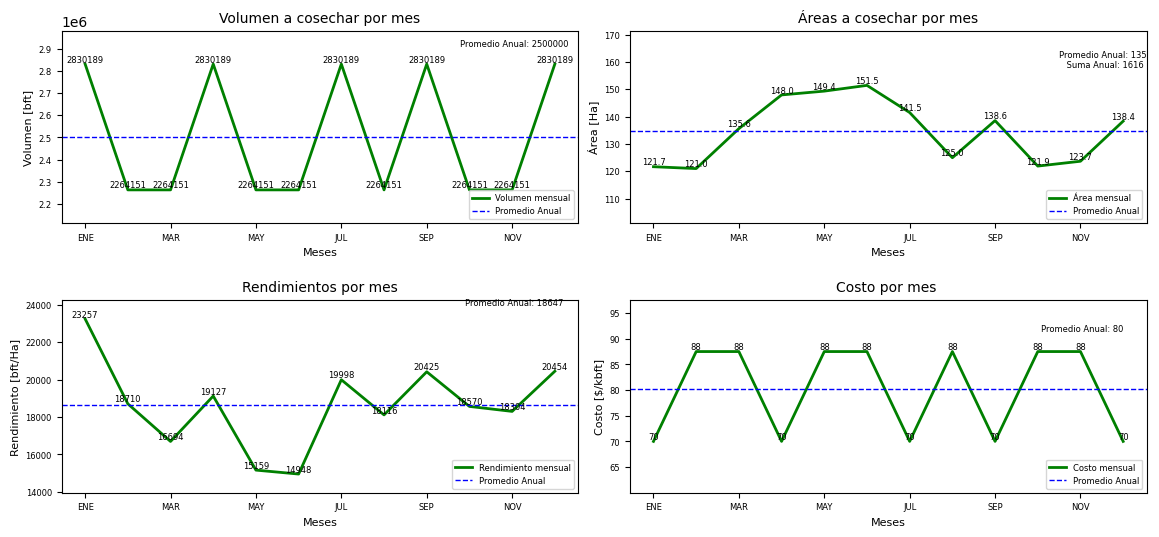

In [181]:
# ------------------------------------------------------------- MAIN ------------------------------------------------------------------------------

# Importar datos de Drive
baseOpt, titlesOpt = importDriveData()

# Calculos de parametros inic.iales
semMes = semanasPorMes()  # Semana.s por mes
vecVolDeseado, volumenAnual = volumenPorMes(semMes) #Volumen por mes

#Creacion de matrices y vectores de interes
vecAreaTotal, vecAreaNeta, matEdades, matRendNeto, vecPerfilRend, matAccesibilidad, vecCostoActBio, matCostoOpe, matPorcR8, matPromR8, matPorcR11, matPromR11, vecRaleo, vecSitioAnio = dataInteres(baseOpt)

# Aplicacion de restricciones
matRendRestr, filas, columnas, areaMaxDes = restrPlanificacion(matRendNeto, matEdades, matAccesibilidad, vecRaleo)

#Ejecucion del modelo
areasOptimizadas = modeloOptimizacion(filas, columnas, vecAreaNeta, vecCostoActBio, matRendRestr, matPromR8, matPromR11, matPorcR8, matPorcR11, areaMaxDes, volumenAnual, vecVolDeseado)

# Presentacion de resultados
resMes = presentaResultados(filas, columnas, areasOptimizadas, matRendRestr, vecSitioAnio, vecAreaNeta, vecAreaTotal, vecCostoActBio)


